_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-05-07, 9am

Student name: FILL IN YOUR NAME HERE

# Exercise sheet 3

Not every cluster in the fitted mixture model corresponds to a single neuron’s spikes (i.e. is a ‘single unit’). We will explore different ways of identifying single units and telling them apart from multi unit activity. In all your plots, color-code the clusters consistently. 

If needed, download the data file ```nda_ex_2_*.npy``` from ILIAS and save it in the subfolder ```../data/```. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from scipy.io import loadmat
import copy
from numba import jit, cuda, vectorize
import statistics

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
%pwd

'C:\\Users\\ulzii\\JupyterNote\\SS19\\NeuralDataAnalysis\\HW3'

In [3]:
m = np.load('../data/nda_ex_2_means.npy')
S = np.load('../data/nda_ex_2_covs.npy')
a = np.load('../data/nda_ex_2_labels.npy')
p = np.load('../data/nda_ex_2_pis.npy')

b = np.load('../data/nda_ex_1_features.npy')
t = np.load('../data/nda_ex_1_spiketimes_t.npy')
w = np.load('../data/nda_ex_1_waveforms.npy')
k = len(p);


## Task 1: Visual inspection of clusters

The most obvious candidates for single units are clusters that you can identify visually as being well separated from the rest. You can use the plotting function you implemented last week (Exercise 2 Task 4) as a first tool to identify putative single units. Of course there may be other less obvious cases in the data.

*Grading: 0 pts*


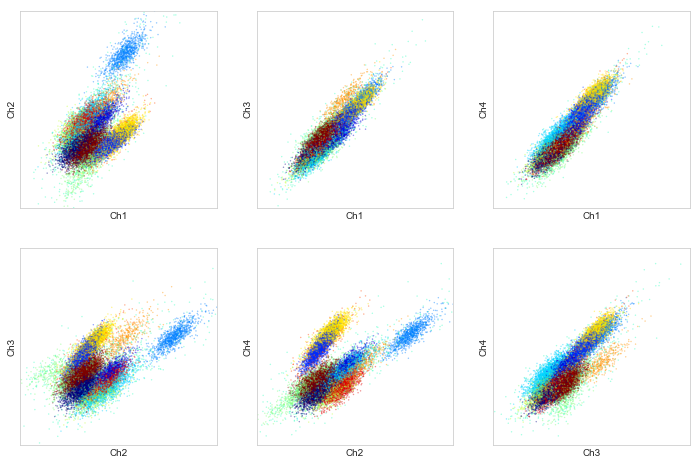

In [4]:
colors = plt.cm.jet(np.linspace(0,1,max(a)+1))
# plot
fig = plt.figure(figsize=(12, 8))
c = np.squeeze(colors[a])

idx = [0, 3, 6, 9]
pl = 1

labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,pl, aspect='equal')
        ax.scatter(b[:,idx[i]], b[:,idx[j]], c=c, s=.7,marker='.',alpha=0.5) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-800,1300))
        plt.ylim((-800,1300))
        ax.set_xticks([])
        ax.set_yticks([])
        pl = pl+1

## Task 2: Visual inspection of waveforms

Plot the average waveforms and 100 examples from each cluster. This is a good sanity check and helps to identify potential artifacts such as electrical noise or clusters representing overlapping spikes (they often have large variance and few spikes). 

*Grading: 2 pts*


In [5]:
def plotWaveforms(w,assignment, clusters=':', waveforms=20,figure=4):
# Plot waveforms for each cluster.
#  plotWaveforms(w, assignment) plots for all four channels of each
#  cluster 100 sample waveforms, overlaid by the average waveform. All
#  panels are drawn on the same scale to facilitate comparison.
    x = ['Ch1', 'Ch2', 'Ch3', 'Ch4'];
    Fs = 30000;
    dt = 1/Fs;
    t = np.arange(-10,20) * dt * 1000;
    
    plt.figure(figsize=(20, 30));

    for i, col in enumerate(x): 
        for j in range(k):
            plt.subplot(k,len(x),i*k+j + 1);       
            tmp_w = w[:,assignment == j,i:i+1];
            plt.plot(t,tmp_w[:,1:waveforms,0],'k', linewidth=1);
            tmp_w_ave = np.mean(tmp_w[:,:,0:1], axis = 1);
            plt.plot(t,tmp_w_ave, 'r', linewidth=2);
            
            plt.ylim((-600, 250));
            plt.xlim((-0.33,0.66));

# fill in your code here

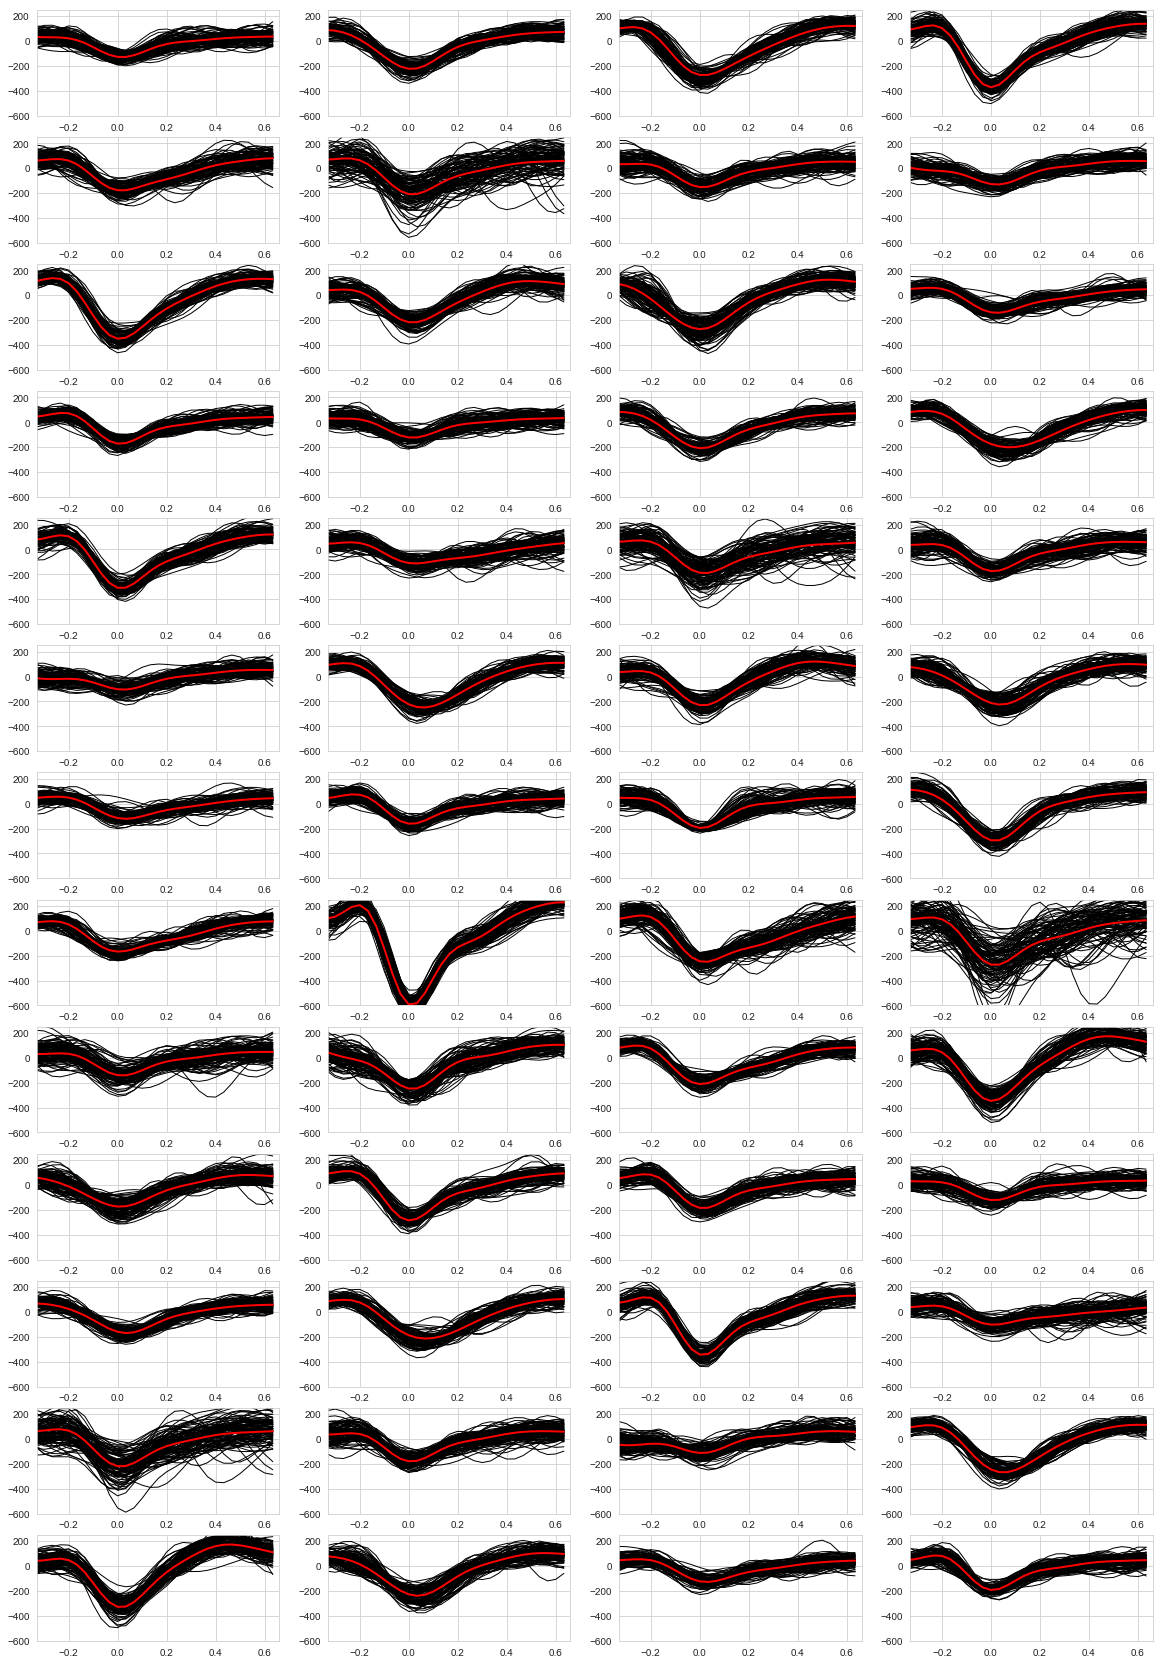

In [6]:
# plot
plotWaveforms(w,a,waveforms=100)


## Task 3: Auto/cross-correlation
Implement a function to calculate the auto/cross-correlograms of all clusters/pairs of clusters called `correlogram()`. Correlograms are useful mostly for two reasons:

* To identify clusters that represent multi unit activity. Neurons have a refractory period: after firing a spike they cannot fire another spike within a period of time (at least 1 ms, often more, depending on the cell type). Thus, if multiple cells contribute to one cluster, it won’t have a refractory period. 
* To identify two (or more) clusters that represent the same single unit: if this is the case the cross-correlogram of the two clusters should show the refractory period, since it consists of spikes from only one cell, which cannot occur too close to each other. 

Plot a matrix with cross- and auto-correlograms like shown in the lecture. Use a bin size of 0.5 ms and a range of ±20 ms. Which auto-correlograms show a refractory period? Which cross-correlograms do?   

You need to take some care to ensure that the implementation of the crosscorrelogram function is efficient, otherwise this may take a while.


*Grading: 4 pts*



In [7]:
# @jit(nopython=True)
def correlogram(t, assignment, binsize, maxlag):
# Calculate cross correlogram
#   ccg = correlogram(t, assignment, binsize, maxlag) calculates the 
#   cross- and autocorrelograms for all pairs of clusters with input
#       t               spike times             #spikes x 1
#       assignment      cluster assignments     #spikes x 1
#       binsize         bin size in ccg         scalar
#       maxlag          maximal lag             scalar
# 
#    and output
#       ccg             computed correlograms   #bins x #clusters x
#                                                               #clusters
#       bins            bin times relative to center    #bins x 1
    
    bin_length = maxlag*2;
    ccg = np.zeros((bin_length, k, k));
    
    for i in range(k):
        t_ith = t[assignment == i];
        for j in range(i, k):
            if i == j:
                t_jth = t_ith;
            else:
                t_jth = t[assignment == j];
            
            for ith_iter in range(len(t_ith)):
                t_j_minus_i = t_jth - t_ith[ith_iter];
                window = t_j_minus_i[abs(t_j_minus_i)<maxlag];
                bin_count = np.bincount(np.floor((window + maxlag) / binsize).astype(int), minlength=bin_length);
                ccg[:, i, j] = ccg[:, i, j] + bin_count;
                
                if i != j:
                    ccg[:, j, i] = ccg[:, j, i] + np.flipud(bin_count);
            
            if i == j:
                ccg[int(bin_length/2), i, i] = ccg[int(bin_length/2), i, i] - t_ith.size;
    
    bins = np.arange(-maxlag, maxlag, 1);
    # fill in your code here
    
    return (ccg, bins)
    

In [8]:
def plotCCG(ccg, bins, figure=2, axis='off'):
#Plot cross-correlograms of all pairs.
#   plotCCG(ccg,bins) plots a matrix of cross(auto)-correlograms for
#   all pairs of clusters. Inputs are:
#       ccg     array of cross correlograms           #bins x #clusters x #clusters
#       bins    array with bin timings                #nbins x 0
    
    colors = plt.cm.jet(np.linspace(0,1,ccg.shape[1]+1))
    
    # plot
    fig = plt.figure(figure, figsize=(12, 10))
    plt.clf

    bg = 0.7*np.ones(3)
    
    K = ccg.shape[1] 
    
    for ix in range(K):
        for jx in range(K):
            ax = plt.subplot(K,K,K*ix+jx+1, facecolor=bg)
            
            if ix == jx:
                ax.bar(bins, ccg[:, ix, jx], width=1, facecolor=colors[ix, :], edgecolor=colors[ix, :])
            else:
                ax.bar(bins, ccg[:, ix, jx], width=1, facecolor='k')
            ax.axis(axis)
            ax.set_xlim(1.2 * bins[[0,-1]])
            ylim = np.array(list(ax.get_ylim()))
            ax.set_ylim(np.array([0, 1.2]) * ylim)
            ax.set_yticks([])

            if ix != jx:
                ax.plot(0, 0, '*', c=colors[jx, :])
                
            if ix != K-1:
                ax.set_xticks([])
                
            if ix == K-1:
                ax.set_xlabel('ms')


In [9]:
(ccg, bins) = correlogram(t,a,1,20)

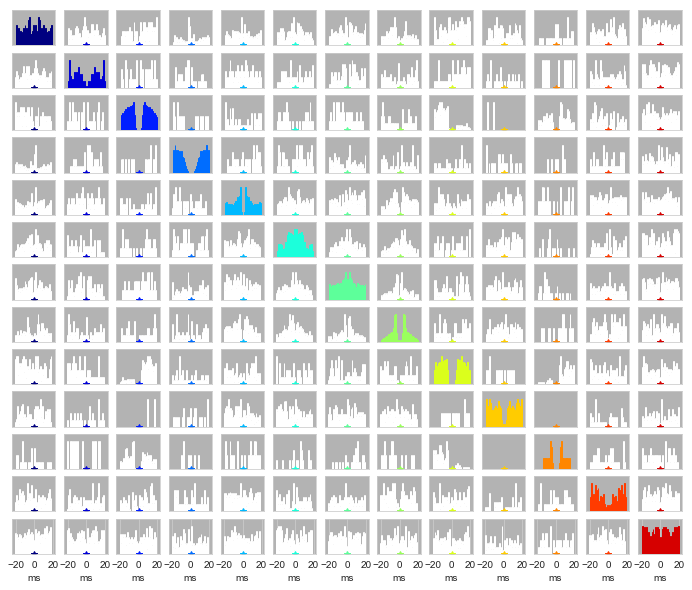

In [10]:
plotCCG(ccg,bins,axis='on')

### Task 4: Cluster separation
Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.


*Grading: 4 pts*


In [11]:
def separation(b, m, S, p, assignment, nbins=50, figure=3):
# Calculate cluster separation
#   proj, bins = separation(b, m, S, p, assignment) 
#   projects the data on the LDA axis for all pairs of clusters. The result
#   is normalized such that the left (i.e. first) cluster has 
#   zero mean and unit variances. The LDA axis is estimated from the model.
#   
#       b               features             #spikes x #features
#       m               mean                 #clusters x #features
#       S               covariances          #features x # features x #clusters
#       p               priors               #clusters x 1
#       assignment      cluster assignments     #spikes x 1
# 
#  and output
#       proj            computed lda histograms   #bins x #clusters x
#                                                               #clusters
#       bins            bin times relative to center    #bins x 1    
   
    K = np.max(assignment)+1
    colors = plt.cm.jet(np.linspace(0,1,K))
        
    fig = plt.figure(figure, figsize=(12, 12))
    plt.clf

    bg = 0.7*np.ones(3)
    
    proj = np.zeros((nbins * K * K))
    for ix in range(K):
        for jx in np.delete(np.arange(0,K), ix):

            # fill in your code here
            
            # LDA
            S_sum_inv = S[:,:,ix]+S[:,:,jx];
            S_sum_inv = np.linalg.inv(S_sum_inv);
            m_sub = m[jx,:] - m[ix,:];            
            
            w = np.matmul(S_sum_inv, m_sub);
            
            qi = np.matmul(b[assignment==ix,:]-m[jx,:], w);
            qj = np.matmul(b[assignment==jx,:]-m[jx,:], w);

            norm_std_j = statistics.stdev(qj);
            
#             normalization
            qi = (qi) / norm_std_j;
            qj = (qj) / norm_std_j;
        
            # plot histograms on optimal axis
            
            ax = plt.subplot(K,K,ix*K+jx+1, facecolor=bg)
            bins = np.linspace(-3, 10, nbins)
            h = np.array([np.histogram(qj, bins)[0], np.histogram(qi, bins)[0]])
            ax.bar(bins[1:-1], h[0,1:], 1, facecolor=colors[jx], edgecolor = colors[jx], linestyle=None)
            ax.bar(bins[1:-1], h[1,1:], 1, facecolor=colors[ix], edgecolor = colors[ix])
                        
            ax.set_ylim([0, 1.2 * np.max(h[0, :])])
            ax.set_xlim([-3, 10])
            ax.set_yticks([])
            ax.set_xticks([])
            


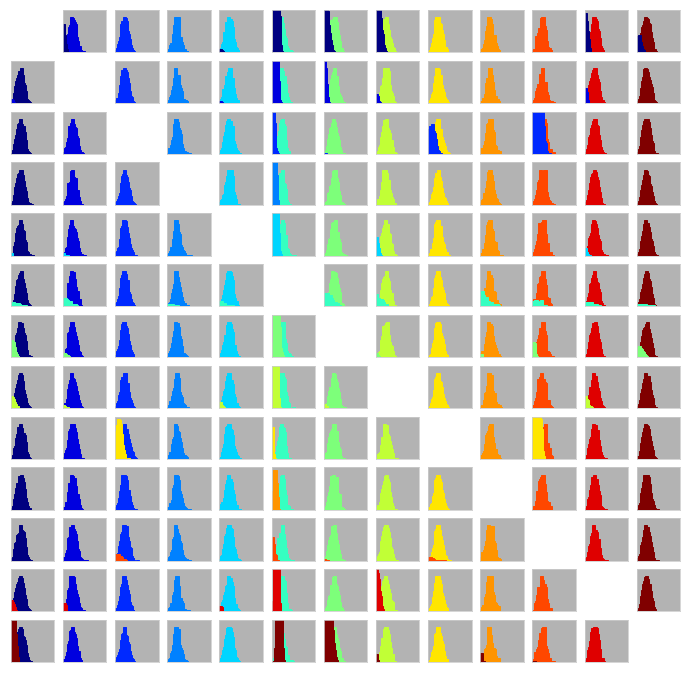

In [12]:
separation(b,m,S,p,a)

## Task 5: Identify putative single units. 

Use all of the above tools to identify all putative single units in the dataset. Which ones are these and why?

Type _Markdown_ and Latex: $\alpha^2$

From the Correlogram we can see that 2, 3, 8, 10 shows single unit activity. Also, correlogram shows 2 and 3 could be single unit activity. So there could be 3 single units.